![Course header](../assets/img/header.png)

## Part 4 — Plotting, Composites & NDVI Analysis

### Agenda (Part 4)

- **Single-band maps** and **RGB composites** (true colour & false colour)
- **Time series plots** — tracking reflectance and indices over time
- **Temporal composites** — median, mean, cloud-free
- **NDVI** — compute, map, mask, threshold, and interpret

**By the end you should be able to**: visualise any band or index as a map or time series, produce cloud-free composites, and run a basic NDVI analysis.

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from pystac_client import Client
import planetary_computer as pc
from odc.stac import stac_load

# Matplotlib defaults for notebooks
plt.rcParams["figure.figsize"] = (10, 4)

In [6]:
from tqdm.auto import tqdm
STAC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
COLLECTION = "sentinel-2-l2a"
bbox = (9.8, 49.7, 10, 49.82)
crs = "EPSG:32632"  
catalog = Client.open(STAC_URL)
datetime = "2022-01-01/2022-07-31"
cloud_cover_lt = 20
query = {"eo:cloud_cover": {"lt": cloud_cover_lt}}
search = catalog.search(
    collections=[COLLECTION],
    bbox=bbox,
    datetime=datetime,
    query=query,
)
items = list(search.get_items())
bands = ["B02", "B03", "B04", "B08", "SCL"]
resampling = {"*": "bilinear", "SCL": "nearest"}
ds_raw = stac_load(
    items,
    bbox=bbox,
    bands=bands,
    crs=crs,
    resolution=20,
    patch_url=pc.sign,
    dtype="uint16",
    nodata=0,
    groupby="solar_day",
    resampling=resampling,
    progress=tqdm,
)

ds_raw

100%|██████████| 110/110 [01:27<00:00,  1.25it/s]


<xarray.Dataset> Size: 108MB
Dimensions:      (y: 676, x: 729, time: 22)
Coordinates:
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
  * time         (time) datetime64[us] 176B 2022-01-19T10:32:49.024000 ... 20...
    spatial_ref  int32 4B 32632
Data variables:
    B02          (time, y, x) uint16 22MB 232 195 113 95 ... 1186 1179 1167 1169
    B03          (time, y, x) uint16 22MB 342 285 185 141 ... 1366 1362 1354
    B04          (time, y, x) uint16 22MB 417 367 230 203 ... 1163 1150 1151
    B08          (time, y, x) uint16 22MB 1265 1294 1073 777 ... 4280 4274 4347
    SCL          (time, y, x) uint16 22MB 7 7 2 2 2 4 4 4 4 ... 4 4 4 4 4 4 4 4

In [10]:
rename_map = {"B02": "blue", "B03": "green", "B04": "red", "B08": "nir", "SCL": "scl"}
present = {k: v for k, v in rename_map.items() if k in ds_raw.data_vars}
ds = ds_raw.rename(present)
ds

<xarray.Dataset> Size: 108MB
Dimensions:      (y: 676, x: 729, time: 22)
Coordinates:
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
  * time         (time) datetime64[us] 176B 2022-01-19T10:32:49.024000 ... 20...
    spatial_ref  int32 4B 32632
Data variables:
    blue         (time, y, x) uint16 22MB 232 195 113 95 ... 1186 1179 1167 1169
    green        (time, y, x) uint16 22MB 342 285 185 141 ... 1366 1362 1354
    red          (time, y, x) uint16 22MB 417 367 230 203 ... 1163 1150 1151
    nir          (time, y, x) uint16 22MB 1265 1294 1073 777 ... 4280 4274 4347
    scl          (time, y, x) uint16 22MB 7 7 2 2 2 4 4 4 4 ... 4 4 4 4 4 4 4 4

In [11]:
for name in list(ds.data_vars):
    if name == "scl":
        continue
    ds[name] = ds[name].astype("float32") * 1e-4
ds

<xarray.Dataset> Size: 195MB
Dimensions:      (y: 676, x: 729, time: 22)
Coordinates:
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
  * time         (time) datetime64[us] 176B 2022-01-19T10:32:49.024000 ... 20...
    spatial_ref  int32 4B 32632
Data variables:
    blue         (time, y, x) float32 43MB 0.0232 0.0195 ... 0.1167 0.1169
    green        (time, y, x) float32 43MB 0.0342 0.0285 ... 0.1362 0.1354
    red          (time, y, x) float32 43MB 0.0417 0.0367 0.023 ... 0.115 0.1151
    nir          (time, y, x) float32 43MB 0.1265 0.1294 ... 0.4274 0.4347
    scl          (time, y, x) uint16 22MB 7 7 2 2 2 4 4 4 4 ... 4 4 4 4 4 4 4 4

---
### 1) Single-band maps

xarray's `.plot()` wraps `matplotlib.pcolormesh` — for a 2-D array it automatically produces a map with a colorbar and coordinate labels.

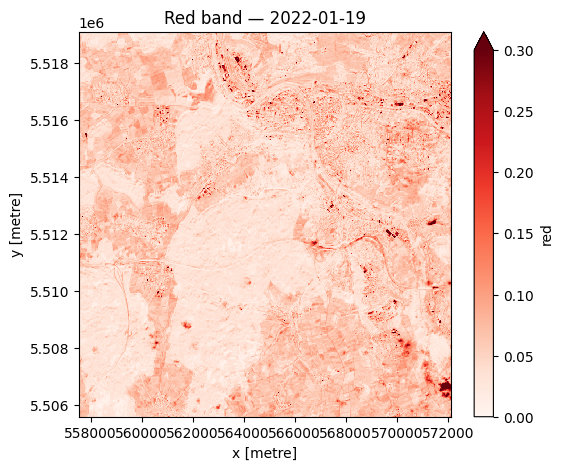

In [12]:
# ── Single-band map ──────────────────────────────────────────────
ds.red.isel(time=0).plot(figsize=(6, 5), cmap="Reds", vmin=0, vmax=0.3)
plt.title(f"Red band — {str(ds.time[0].values)[:10]}")
plt.show()

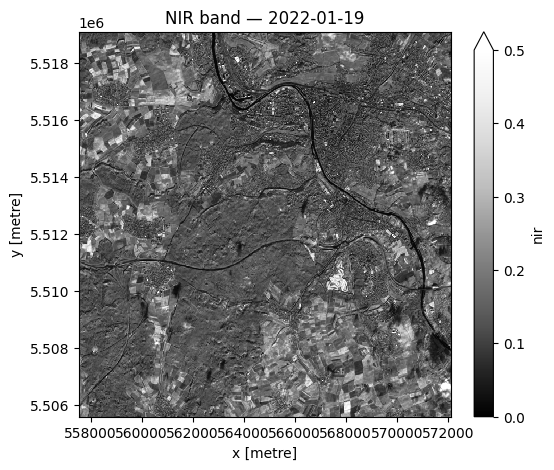

In [13]:
# NIR band map
ds.nir.isel(time=0).plot(figsize=(6, 5), cmap="Greys_r", vmin=0, vmax=0.5)
plt.title(f"NIR band — {str(ds.time[0].values)[:10]}")
plt.show()

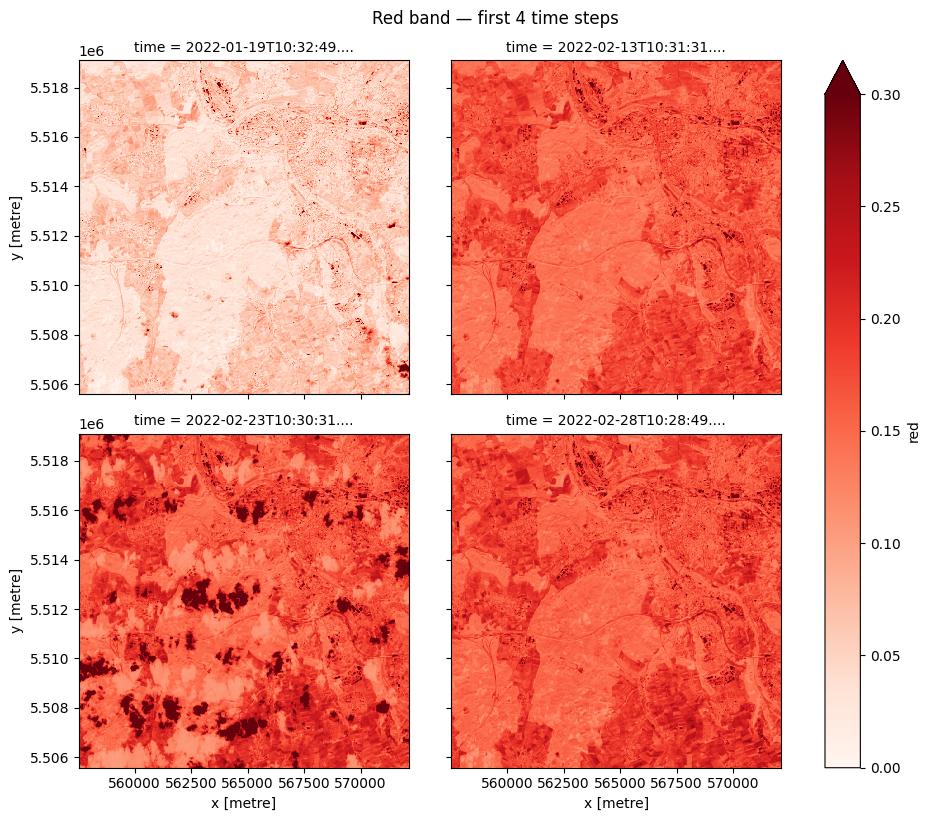

In [14]:
# Faceted plot — multiple time steps side by side
ds.red.isel(time=slice(0, 4)).plot(
    col="time", col_wrap=2, figsize=(10, 8),
    cmap="Reds", vmin=0, vmax=0.3,
)
plt.suptitle("Red band — first 4 time steps", y=1.02)
plt.show()

### 2) RGB composites

To display a true-colour image we stack three bands (red, green, blue) into a 3-channel array and pass it to `plt.imshow()`.

A **helper function** makes this reusable.

In [15]:
def plot_rgb(ds, time_idx=0, bands=("red", "green", "blue"),
             stretch=0.3, figsize=(6, 6), title=None):
    """Plot an RGB composite from a Dataset at one time step."""
    scene = ds.isel(time=time_idx)
    rgb = xr.concat([scene[b] for b in bands], dim="band").transpose("y", "x", "band")
    rgb_display = np.clip(rgb.values / stretch, 0, 1)

    plt.figure(figsize=figsize)
    plt.imshow(rgb_display)
    plt.title(title or f"RGB — {str(ds.time[time_idx].values)[:10]}")
    plt.axis("off")
    plt.show()

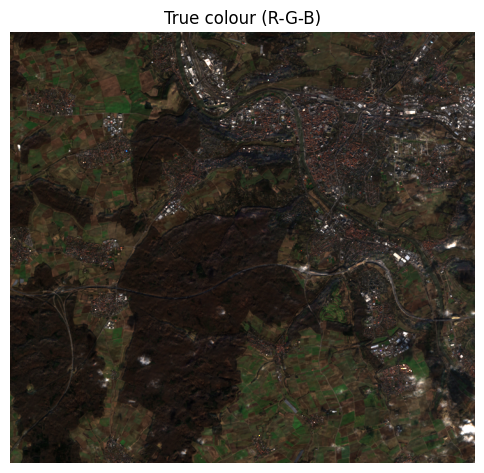

In [16]:
# True-colour composite
plot_rgb(ds, time_idx=0, title="True colour (R-G-B)")

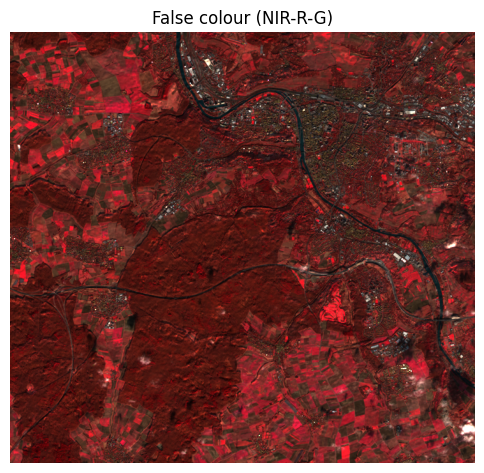

In [17]:
# False-colour composite (NIR–Red–Green) — vegetation appears red/orange
plot_rgb(ds, time_idx=0, bands=("nir", "red", "green"),
         stretch=0.4, title="False colour (NIR-R-G)")

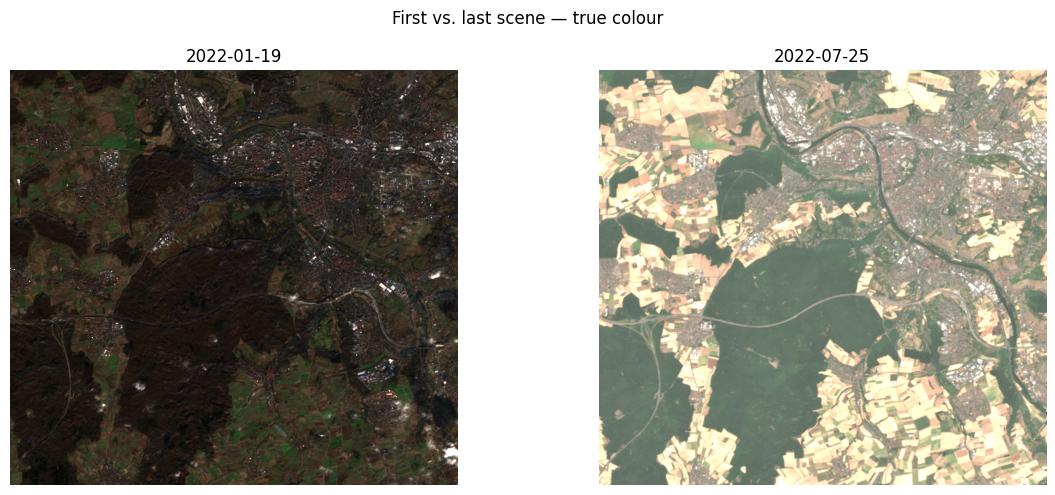

In [18]:
# Compare two dates side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, t_idx in zip(axes, [0, -1]):
    scene = ds.isel(time=t_idx)
    rgb = xr.concat([scene.red, scene.green, scene.blue], dim="band").transpose("y", "x", "band")
    ax.imshow(np.clip(rgb.values / 0.3, 0, 1))
    ax.set_title(str(ds.time[t_idx].values)[:10])
    ax.axis("off")
plt.suptitle("First vs. last scene — true colour")
plt.tight_layout()
plt.show()

### 3) Time series plots
Reducing the spatial dimensions (`x`, `y`) to a single value per time step turns any band or index into a **time series**.


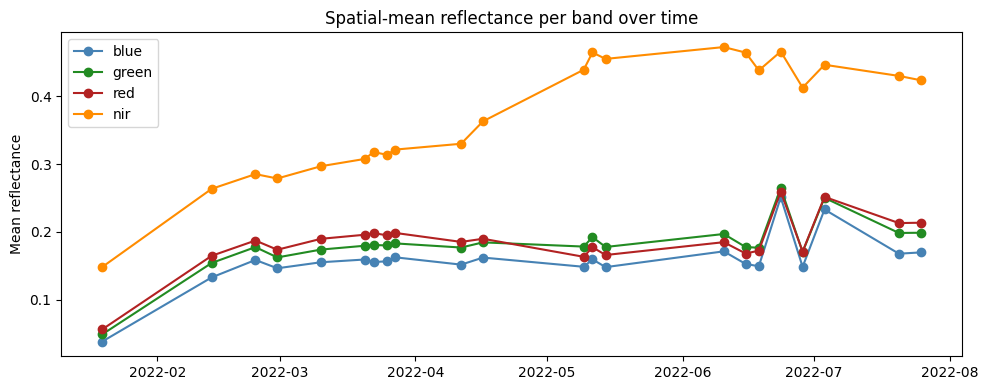

In [20]:
# Multi-band time series (spatial mean)
fig, ax = plt.subplots(figsize=(10, 4))
for band, color in [("blue", "steelblue"), ("green", "forestgreen"),
                      ("red", "firebrick"), ("nir", "darkorange")]:
    ts = ds[band].mean(dim=["x", "y"])
    ax.plot(ts.time, ts.values, marker="o", label=band, color=color)

ax.set_ylabel("Mean reflectance")
ax.set_title("Spatial-mean reflectance per band over time")
ax.legend()
plt.tight_layout()
plt.show()

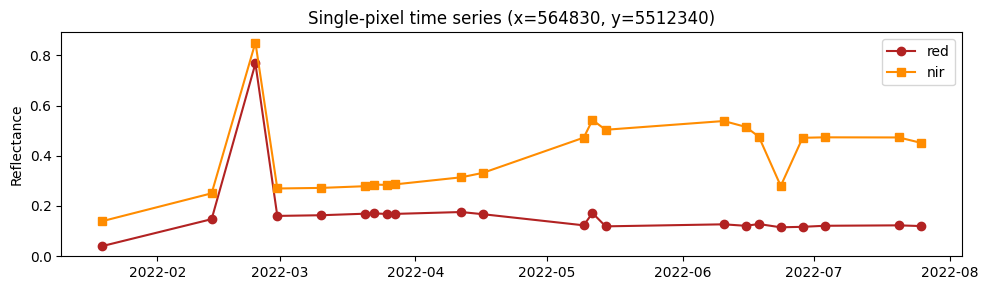

In [21]:
# Single-pixel time series
# Pick a pixel near the centre of the AOI
x_mid = float(ds.x.median())
y_mid = float(ds.y.median())

pixel = ds.sel(x=x_mid, y=y_mid, method="nearest")

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(pixel.time, pixel.red.values, "o-", color="firebrick", label="red")
ax.plot(pixel.time, pixel.nir.values, "s-", color="darkorange", label="nir")
ax.set_ylabel("Reflectance")
ax.set_title(f"Single-pixel time series (x={x_mid:.0f}, y={y_mid:.0f})")
ax.legend()
plt.tight_layout()
plt.show()

### 4) Temporal composites

A **composite** collapses the time dimension into a single representative image. Choosing the right aggregation matters:

| Method | Effect | Best for |
|--------|--------|----------|
| `mean` | Averages all values | Smooth estimate, sensitive to outliers/clouds |
| `median` | Middle value | Robust to outliers — the standard EO choice |
| `max` | Brightest pixel | Snow, peak greenness |
| `min` | Darkest pixel | Cloud shadows, water |
```

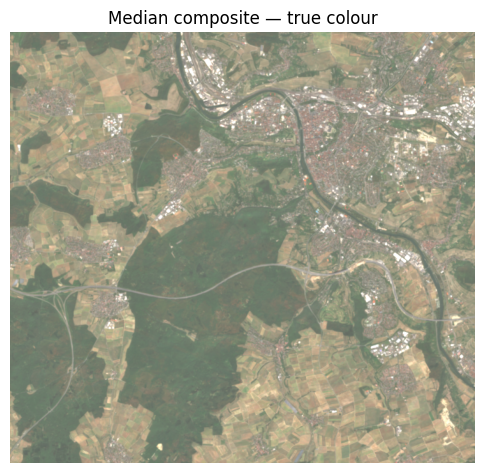

In [22]:
# Median composite
composite_median = ds[["red", "green", "blue", "nir"]].median(dim="time")

plot_data = xr.concat([composite_median.red, composite_median.green, composite_median.blue],
                       dim="band").transpose("y", "x", "band")
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(plot_data.values / 0.3, 0, 1))
plt.title("Median composite — true colour")
plt.axis("off")
plt.show()

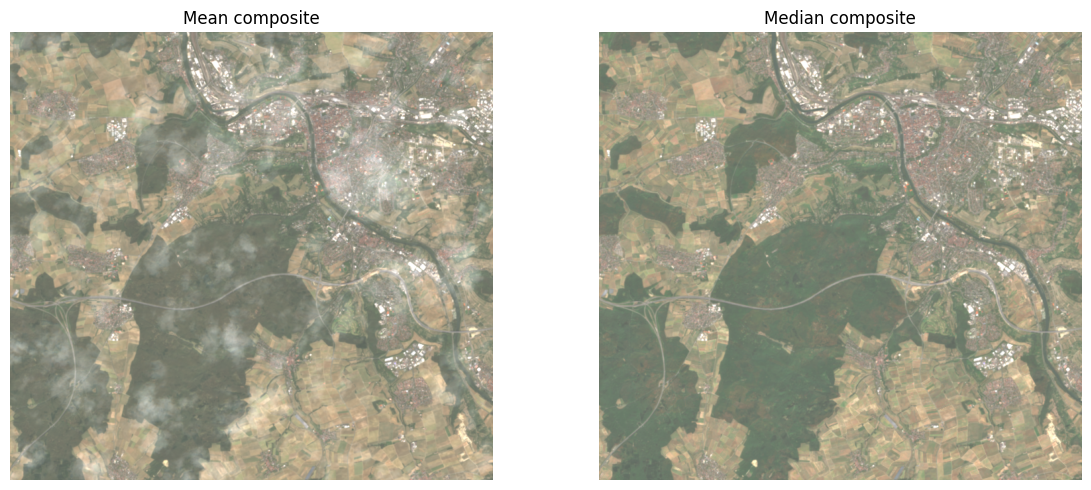

In [23]:
# Mean vs. Median side by side
composite_mean = ds[["red", "green", "blue"]].mean(dim="time")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, comp, label in zip(axes,
                            [composite_mean, composite_median],
                            ["Mean", "Median"]):
    rgb = xr.concat([comp.red, comp.green, comp.blue], dim="band").transpose("y", "x", "band")
    ax.imshow(np.clip(rgb.values / 0.3, 0, 1))
    ax.set_title(f"{label} composite")
    ax.axis("off")
plt.tight_layout()
plt.show()

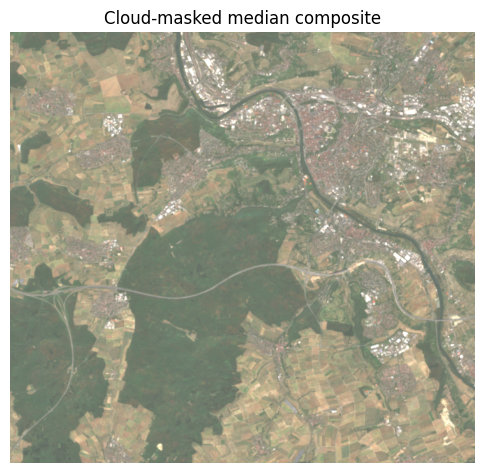

In [24]:
# Cloud-masked median composite (using SCL)
clear_mask = ds.scl.isin([4, 5, 6, 7])  # vegetation, bare soil, water, unclassified
ds_clear = ds.where(clear_mask)

composite_clear = ds_clear[["red", "green", "blue", "nir"]].median(dim="time")

rgb_clear = xr.concat([composite_clear.red, composite_clear.green, composite_clear.blue],
                       dim="band").transpose("y", "x", "band")
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(rgb_clear.values / 0.3, 0, 1))
plt.title("Cloud-masked median composite")
plt.axis("off")
plt.show()

5) NDVI — Normalized Difference Vegetation Index

### 5) NDVI — Normalized Difference Vegetation Index

$$
\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}
$$

| NDVI range | Interpretation |
|-----------|----------------|
| < 0 | Water, snow, clouds |
| 0 – 0.2 | Bare soil, rock, impervious surfaces |
| 0.2 – 0.4 | Sparse / stressed vegetation |
| 0.4 – 0.6 | Moderate vegetation |
| > 0.6 | Dense, healthy vegetation |
```

In [25]:
# Compute NDVI for all time steps
ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)
ndvi.name = "ndvi"

print(f"NDVI shape: {ndvi.shape}")
print(f"NDVI range: {float(ndvi.min()):.2f} – {float(ndvi.max()):.2f}")

NDVI shape: (22, 676, 729)
NDVI range: -0.73 – 1.00


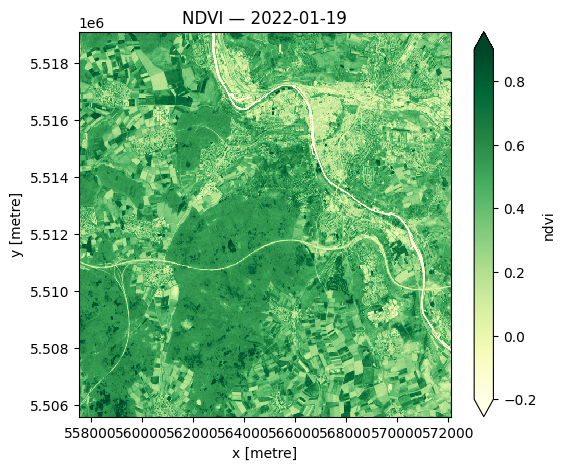

In [26]:
# NDVI map — single time step
ndvi.isel(time=0).plot(figsize=(6, 5), cmap="YlGn", vmin=-0.2, vmax=0.9)
plt.title(f"NDVI — {str(ds.time[0].values)[:10]}")
plt.show()

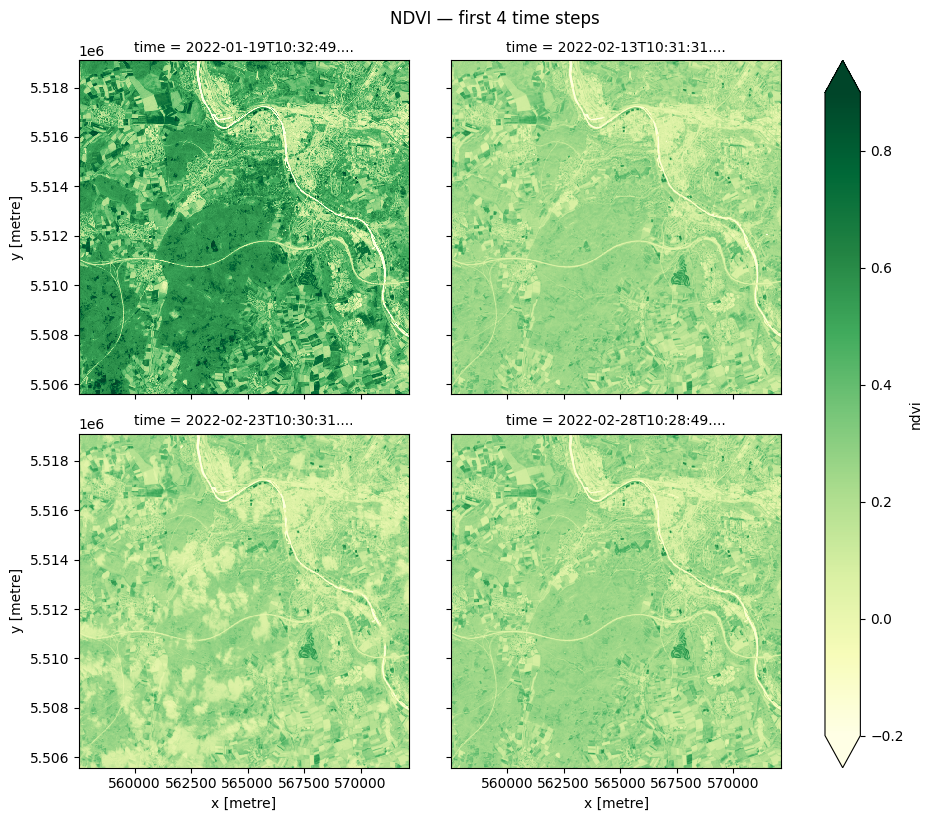

In [27]:
# NDVI — faceted over time
ndvi.isel(time=slice(0, 4)).plot(
    col="time", col_wrap=2, figsize=(10, 8),
    cmap="YlGn", vmin=-0.2, vmax=0.9,
)
plt.suptitle("NDVI — first 4 time steps", y=1.02)
plt.show()

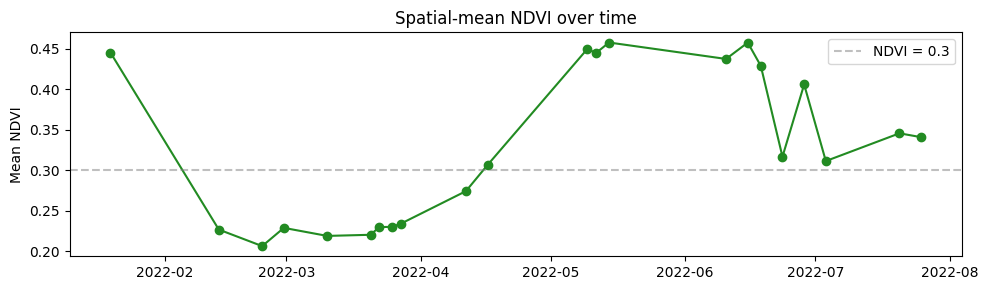

In [29]:
# NDVI time series (spatial mean)
ndvi_ts = ndvi.mean(dim=["x", "y"])

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(ndvi_ts.time, ndvi_ts.values, "o-", color="forestgreen")
ax.set_ylabel("Mean NDVI")
ax.set_title("Spatial-mean NDVI over time")
ax.axhline(0.3, color="grey", ls="--", alpha=0.5, label="NDVI = 0.3")
ax.legend()
plt.tight_layout()
plt.show()

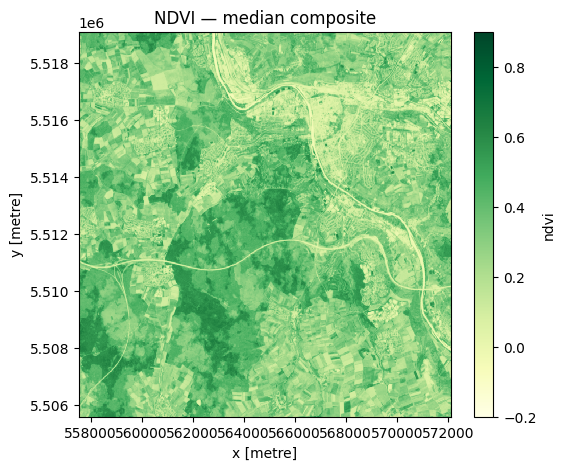

In [30]:
# NDVI median composite
ndvi_median = ndvi.median(dim="time")

ndvi_median.plot(figsize=(6, 5), cmap="YlGn", vmin=-0.2, vmax=0.9)
plt.title("NDVI — median composite")
plt.show()


### Checkpoint (Part 4)

**Exercise 1 — False-colour composite**

Create a false-colour composite (NIR–Red–Green) for the **last** time step. What appears bright red/orange in this visualisation?

<details>
<summary>Show solution</summary>

```python
plot_rgb(ds, time_idx=-1, bands=("nir", "red", "green"),
         stretch=0.4, title="False colour — last time step")
# Bright red/orange = high NIR reflectance → dense, healthy vegetation.
```

</details>

---

**Exercise 2 — Cloud-masked NDVI time series**

Compute a cloud-masked NDVI time series (spatial mean per time step). Compare it with the unmasked version — which dates change the most?

<details>
<summary>Show solution</summary>

```python
clear_mask = ds.scl.isin([4, 5, 6, 7])
ndvi_all = ndvi.mean(dim=["x", "y"])
ndvi_clear_ts = ndvi.where(clear_mask).mean(dim=["x", "y"])

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(ndvi_all.time, ndvi_all.values, "o-", label="all pixels")
ax.plot(ndvi_clear_ts.time, ndvi_clear_ts.values, "s-", label="cloud-masked")
ax.set_ylabel("Mean NDVI")
ax.set_title("Cloud-masked vs. unmasked NDVI time series")
ax.legend()
plt.tight_layout()
plt.show()
```

</details>

---

**Exercise 3 — NDVI threshold sensitivity**

Try three different NDVI thresholds (0.2, 0.4, 0.6) and plot the vegetation masks side by side. How does the fraction of vegetation pixels change?

<details>
<summary>Show solution</summary>

```python
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, thresh in zip(axes, [0.2, 0.4, 0.6]):
    mask = ndvi_clear_median > thresh
    mask.plot(ax=ax, cmap="Greens", add_colorbar=False)
    pct = 100 * float(mask.sum()) / float(mask.count())
    ax.set_title(f"NDVI > {thresh}  ({pct:.0f}%)")
plt.tight_layout()
plt.show()
```

</details>

---

**Exercise 4 — Monthly NDVI composites**

Resample NDVI to monthly median composites and plot them as a faceted grid.

<details>
<summary>Show solution</summary>

```python
ndvi_monthly = ndvi_clear.resample(time="ME").median()

ndvi_monthly.plot(
    col="time", col_wrap=3, figsize=(12, 8),
    cmap="YlGn", vmin=-0.2, vmax=0.9,
)
plt.suptitle("Monthly NDVI median composites (cloud-masked)", y=1.02)
plt.show()
```

</details>